# Model_AE_Inception_Encoder_and_Decoder

## V5 settings
- Normal AE with Inception modules
- Simplify the inception modules a bit
- "Normal" meaning no latent variable layers
- Simple MSEloss

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchviz import make_dot
import gc

# import image based recommendation module
from ibfilter import ImageBasedRecommendation

---
## Data Prep
---

In [3]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [4]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [5]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [6]:
# # Define transformations and initialize Dataset
# transform_steps = transforms.Compose([transforms.ToTensor(),
#                                       transforms.CenterCrop(200),
#                                       transforms.Normalize(mean=[0], std=[1.0])
#                                      ])
# manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [7]:
# # Set DataLoader

# # Split train and data
# train_size = int(manga_dataset.__len__() * 0.75)
# val_size = int(manga_dataset.__len__() - train_size)
# train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # All dataloader
# all_data_loader = DataLoader(manga_dataset, batch_size=32)

In [8]:
# # Check Dataset
# img_ex = train_dataset.__getitem__(0)
# print(len(img_ex))
# print(type(img_ex))
# print(img_ex[0].shape)

# # Check DataLoader
# input_tensor, output_tensor, character_id = next(iter(train_loader))
# print(f"input batch shape: {input_tensor.size()}")
# print(f"output batch shape: {output_tensor.size()}")
# img_ex = input_tensor[0].squeeze()
# plt.imshow(img_ex, cmap="gray")
# plt.show()

In [9]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## AE with Inception modules
---

In [112]:
# Codes to build individual modules

# encoder modules
def single_encoder_module(in_c, out_c, k, s=1, p=0):
    module = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_downsampling_module(in_c, pooling):
    module = nn.Sequential(nn.AvgPool2d(pooling),
                           nn.Conv2d(in_c, in_c*4, kernel_size=1),
                           nn.BatchNorm2d(in_c*4),
                           nn.ReLU(inplace=True))
    return module


# decoder modules
def single_decoder_module(in_c, out_c, k, s=1, p=0, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, output_padding=op),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_upsampling_module(in_c, pooling, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, in_c//4, kernel_size=pooling, stride=pooling, output_padding=op),
                           nn.BatchNorm2d(in_c//4),
                           nn.ReLU(inplace=True))
    return module

def single_upsampling_module_custom(in_c, out_c, k=1, s=1, p=0, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, output_padding=op),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

In [113]:
# Inception modules

class EncoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 2
        self.bottleneck = single_encoder_module(channels, bn_ch, 1)
        self.conv1 = single_encoder_module(bn_ch, channels, 1)
        self.conv2 = single_encoder_module(bn_ch, channels, 3, p=1)
        self.conv3 = single_encoder_module(bn_ch, channels, 5, p=2)
        self.conv4 = single_encoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.conv1(bn) + self.conv2(bn) + self.conv3(bn) + self.conv4(bn) + self.pool1(x) + self.pool2(x)
        return out


class DecoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 4
        self.bottleneck = single_decoder_module(channels, bn_ch, 1)
        self.deconv1 = single_decoder_module(bn_ch, channels, 1)
        self.deconv2 = single_decoder_module(bn_ch, channels, 3, p=1)
        self.deconv3 = single_decoder_module(bn_ch, channels, 5, p=2)
        self.deconv4 = single_decoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.deconv1(bn) + self.deconv2(bn) + self.deconv3(bn) + self.deconv4(bn) + self.pool1(x) + self.pool2(x)
        return out

In [114]:
# Encoder and decoder modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        self.e_incep1 = EncoderInceptionModule(32)
        self.up_ch2 = single_downsampling_module(32, 4)
        self.e_incep2 = EncoderInceptionModule(128)
        self.up_ch3 = single_downsampling_module(128, 4)
        self.e_incep3 = EncoderInceptionModule(512) # [8, 512, 12, 12]
        # self.flatten = nn.Flatten(start_dim=1) 

    def forward(self, x):
        out = self.e_incep1(self.up_ch1(x))
        out = self.e_incep2(self.up_ch2(out))
        out = self.e_incep3(self.up_ch3(out))
        # out = F.avg_pool2d(out, 6)
        # out = self.flatten(out)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.unflatten = nn.Unflatten(dim=1, unflattened_size=(2048, 1, 1)) # [8, 2048, 1, 1]
        self.d_incep1 = DecoderInceptionModule(512)
        self.down_ch1 = single_upsampling_module_custom(512, 128, k=3, s=2)
        self.d_incep2 = DecoderInceptionModule(128)
        self.down_ch2 = single_upsampling_module_custom(128, 32, k=3, s=2)
        self.d_incep3 = DecoderInceptionModule(32)
        self.down_ch3 = single_upsampling_module_custom(32, 1, k=3, s=2, p=1)
        self.conv1 = nn.ConvTranspose2d(1, 1, kernel_size=1, padding=1, stride=2, output_padding=1)
        self.sig1 = nn.Sigmoid()

    def forward(self, x):
        # out = self.unflatten(x)
        out = self.down_ch1(self.d_incep1(x))
        out = self.down_ch2(self.d_incep2(out))
        out = self.down_ch3(self.d_incep3(out))
        out = self.conv1(out)
        out = self.sig1(out)
        return torch.sigmoid(out)

In [115]:
# AE model with inception modules
class AE_Inception(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

---
## Test runs
---

In [116]:
# !nvidia-smi

In [117]:
# empty gpu cache
torch.cuda.empty_cache()

In [118]:
# test VAE
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      #transforms.RandomRotation(90),
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=8)

# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.001)

# train
losses = []

for epoch in tqdm(range(5)):
    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        out = model(train_img)
        # print(type(z), type(target_img))

        loss = criterion(out, target_img)
        # loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

cuda


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.03s/it]


In [119]:
# !nvidia-smi
# # !kill -9 12547

[0.11198947995901108, 0.11127614378929138, 0.11056989178061485, 0.10994402945041656, 0.10931843802332879]


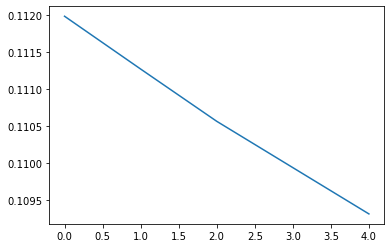

In [120]:
# quick plot of training losses
plt.plot(losses)
print(losses)

In [121]:
model.eval()

# validate
val_losses = []

for epoch in tqdm(range(10)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            out = model(train_img)

            # calculate loss
            loss = criterion(out, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


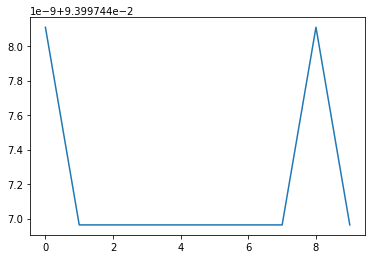

In [122]:
# quick plot of training losses
plt.plot(val_losses)

---
## Train
---

In [123]:
# !nvidia-smi

In [124]:
# version setting
version = "v5"

In [125]:
# visualize model
x = torch.zeros(8, 1, 200, 200, dtype=torch.float, requires_grad=False)
model = AE_Inception(device=device)
model.train()
model.to(device)
out = model(x.to(device))
make_dot(out, params=dict(list(model.named_parameters()))).render(version+"_inception_ae_torchviz", format="png")

'v5_inception_ae_torchviz.png'

In [126]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        optimizer.zero_grad()
        out = model(train_img)
        loss = criterion(out, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()

    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            out = model(train_img)
            loss = criterion(out, target_img)
            running_loss += loss.item()
            
            # clean up
            del train_img, target_img, out, loss
            gc.collect()

        avg_loss = running_loss / counter
        return avg_loss

In [127]:
# empty gpu cache
torch.cuda.empty_cache()

In [131]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=8)


# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.005)

# train
losses = []

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    # print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    # print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), "../assets/character_images/models_and_embeddings/best_model_"+version+".pt")
        min_loss = val_loss
        

cuda


100%|████████████████████████████████████████████████████████████████████████| 100/100 [46:16<00:00, 27.76s/it]


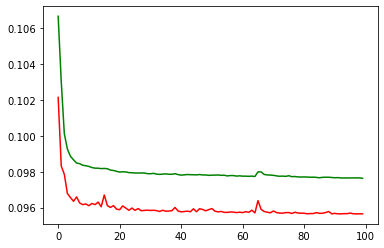

In [132]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
# plt.ylim(0.0, 1000000)
plt.show()

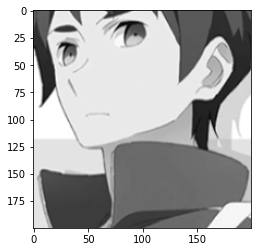

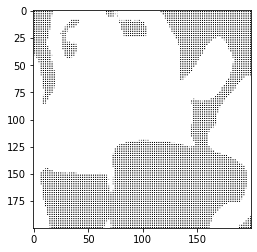

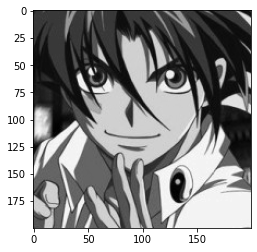

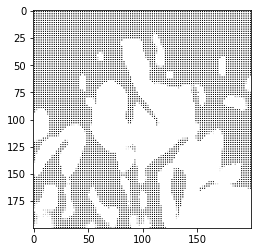

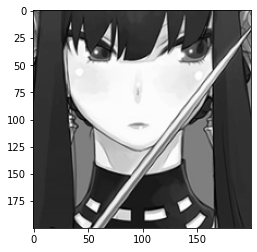

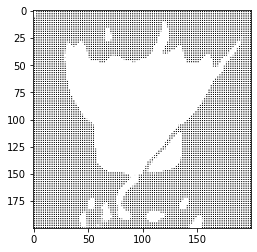

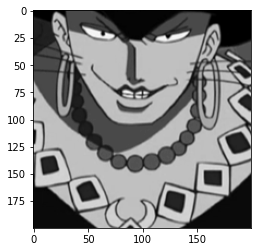

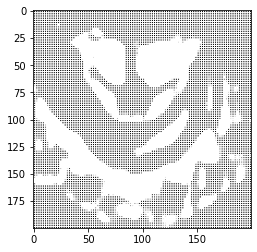

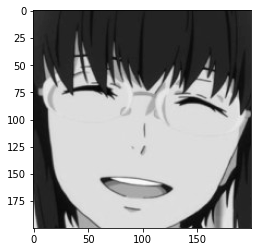

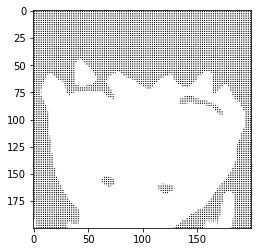

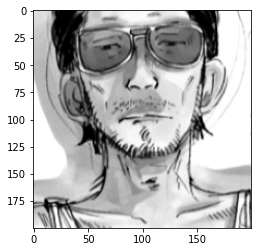

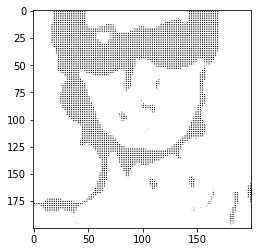

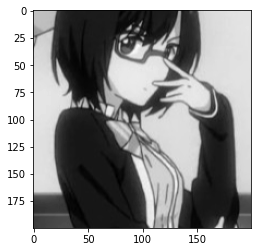

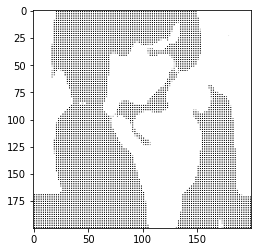

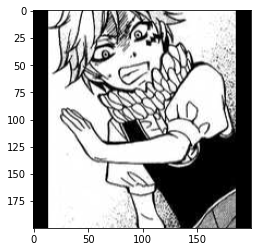

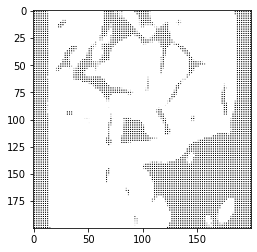

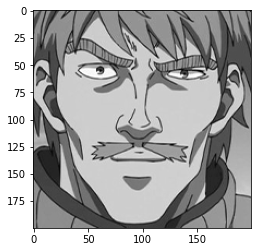

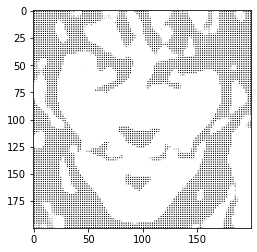

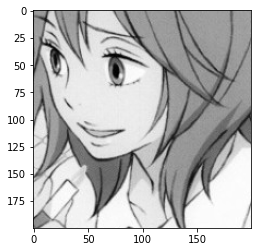

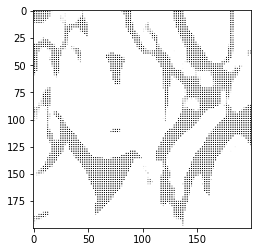

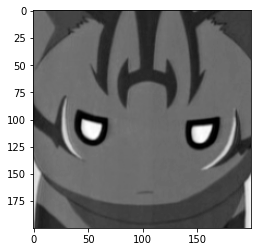

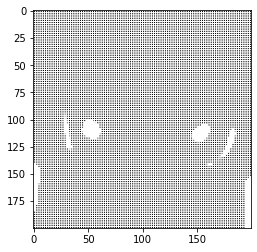

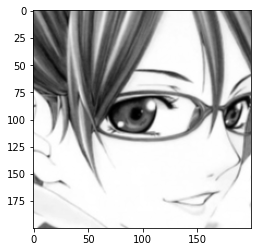

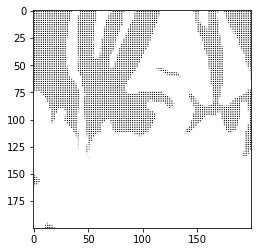

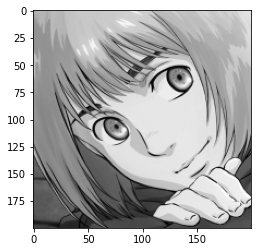

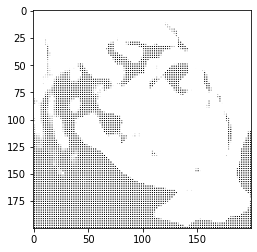

In [133]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        out = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], out[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [135]:
# create embedding

model.eval()
embedding = torch.zeros((1, 512, 12, 12))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in tqdm(all_data_loader):
        train_img = train_img.to(device)
        out = model.encoder(train_img).cpu()
        embedding = torch.cat((embedding, out), 0)
        character_ids.append(character_id)

100%|██████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.68it/s]


In [136]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 512, 12, 12])
shape of flattened embedding:  (500, 73728)


---
## Similarity calculations (Character-based, Title-based)
---

In [3]:
# initialize
ibr_search = ImageBasedRecommendation("/mnt/disks/sdb/home/dy0904k/assets/character_images/character_images_grayscale/", "v5")

model version:  v5


Queried character:  ['Jirou Azuma']  who appears in:  ['BLACK TORCH']


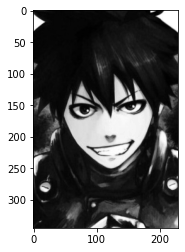

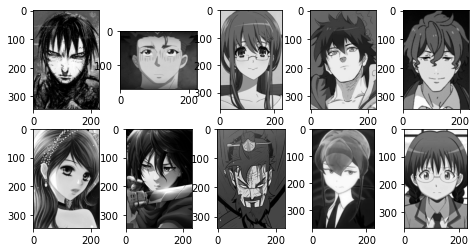

Similar characters (in the order of appearance)
Character:  ['Killy']  who appears in :  ['BLAME!' 'NOiSE' 'Blame! Gakuen And So On' 'BLAME!²'
 'Blame!: Denki Ryoushi Kiken Kaisou Dasshutsu Sakusen' 'BLAME']
Character:  ['Kamioka']  who appears in :  ['Shijou Saikyou no Deshi Kenichi']
Character:  ['Reiko Mikami']  who appears in :  ['Another' 'Another 0']
Character:  ['Han Ye']  who appears in :  ['Yao Shen Ji']
Character:  ['Philip Boreas Greyrat']  who appears in :  ['Mushoku Tensei: Isekai Ittara Honki Dasu']
Character:  ['Teru Kurebayashi']  who appears in :  ['Dengeki Daisy']
Character:  ['Mikasa Ackerman']  who appears in :  ['Shingeki no Kyojin' 'Shingeki no Kyojin: LOST GIRLS'
 'Shingeki! Kyojin Chuugakkou' 'Sungeki no Kyojin'
 'Shingeki! Kyojin Chuugakkou: Seishun! Tonari no Marley Gakuen']
Character:  ['Kwan-Ho Jin']  who appears in :  ['Buggeomjeongi']
Character:  ['Jade']  who appears in :  ['Houseki no Kuni']
Character:  ['Manami Okuda']  who appears in :  ['Ansatsu Kyous

In [4]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=137304, top_n=10)
print(res)

Querying title:  ['Berserk']


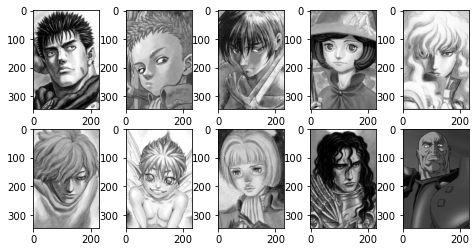

Similar title:  ['Shingeki no Kyojin']


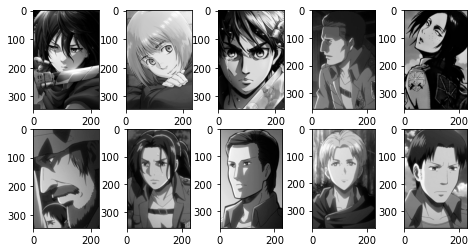

Similar title:  ['Na Honjaman Level Up']


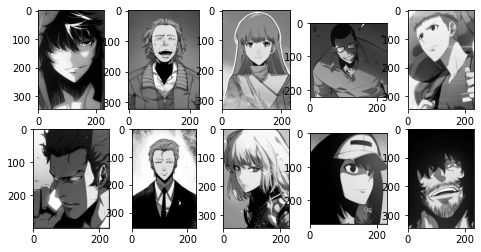

Similar title:  ['Mirai Nikki']


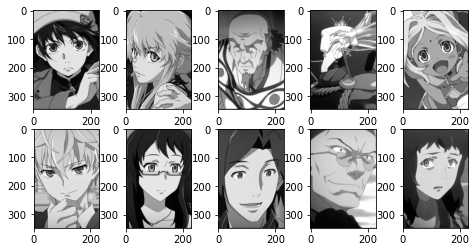

[53390, 105398, 30584]


In [5]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30002, top_n=3)
print(res)